# Import Libraries

In [1]:
import numpy as np # linear algebra
import os
from tqdm import tqdm
from tensorflow import keras
import cv2
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
import matplotlib.pyplot as plt

# Load and Pre-Process data

In [2]:
labels = ['NORMAL','PNEUMONIA']

In [3]:
print("pre-processing data\n")
image_data = []
label_data = []
image_size = 150
data_dirs = ["train","val", "test"]  # List of directories to load data from
for data_dir in data_dirs:
    for i in labels:
        data_path = os.path.join("/kaggle/input/chest-xray-pneumonia/chest_xray/", data_dir, i)
        for m in tqdm(os.listdir(data_path)):
            image = cv2.imread(os.path.join(data_path, m))
            image = cv2.resize(image, (image_size, image_size))
            image_data.append(image)
            label_data.append(i)
image_data = np.array(image_data)
label_data = np.array(label_data)

pre-processing data



100%|██████████| 390/390 [00:04<00:00, 91.31it/s]


In [4]:
image_data,label_data=shuffle(image_data,label_data,random_state=42)
X_train,X_test,Y_train,Y_test=train_test_split(image_data,label_data,test_size=0.2,random_state=42)

In [5]:
train_label_data_new=[]
test_label_data_new=[]
for n in Y_train:
    train_label_data_new.append(labels.index(n))
Y_train=train_label_data_new
Y_train=to_categorical(Y_train)
    
for n in Y_test:
    test_label_data_new.append(labels.index(n))
Y_test=test_label_data_new
Y_test=to_categorical(Y_test)

# VGG16 Model

In [7]:
vgg = VGG16(input_shape=(150,150,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
modelvgg = Model(inputs=vgg.input, outputs=prediction)


In [8]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [9]:
history=modelvgg.fit(X_train,Y_train,
 epochs=10,batch_size= 10,
 validation_data=(X_test,Y_test), callbacks=callback)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - auc: 0.9128 - loss: 1.6195 - val_auc: 0.9560 - val_loss: 1.0363
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - auc: 0.9689 - loss: 0.8028 - val_auc: 0.9573 - val_loss: 1.2216
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - auc: 0.9719 - loss: 0.6833 - val_auc: 0.9397 - val_loss: 2.7039
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - auc: 0.9820 - loss: 0.4660 - val_auc: 0.9515 - val_loss: 1.9728
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - auc: 0.9859 - loss: 0.2625 - val_auc: 0.9517 - val_loss: 1.8240
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - auc: 0.9877 - loss: 0.2921 - val_auc: 0.9484 - val_loss: 2.0615
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - auc: 0.9885 - loss: 0.2675 - val_auc: 0.9628 - val_loss: 1.6218
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - auc: 0.9942 - loss: 0.1395 - val_auc: 0.9559 - val_loss: 2.6995
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 

# Accuracy & Loss

In [10]:
loss, accuracy = modelvgg.evaluate(X_train, Y_train)
print("Train Loss: ", loss)
print("Train Accuracy: ", accuracy)

147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - auc: 0.9743 - loss: 0.4925
Train Loss:  0.4725184440612793
Train Accuracy:  0.9759469628334045


In [11]:
loss, accuracy = modelvgg.evaluate(X_test, Y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - auc: 0.9577 - loss: 1.0455
Test Loss:  1.0363073348999023
Test Accuracy:  0.9559816718101501


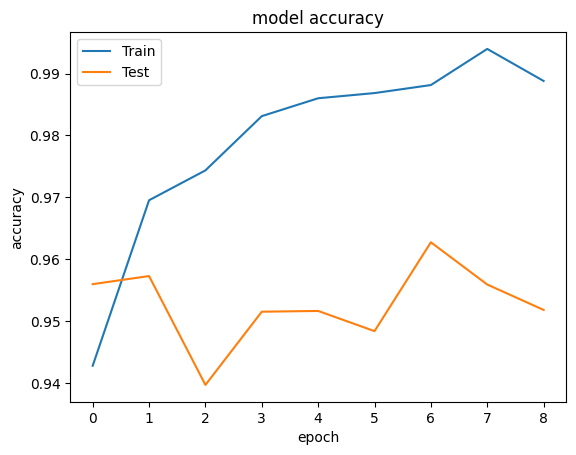

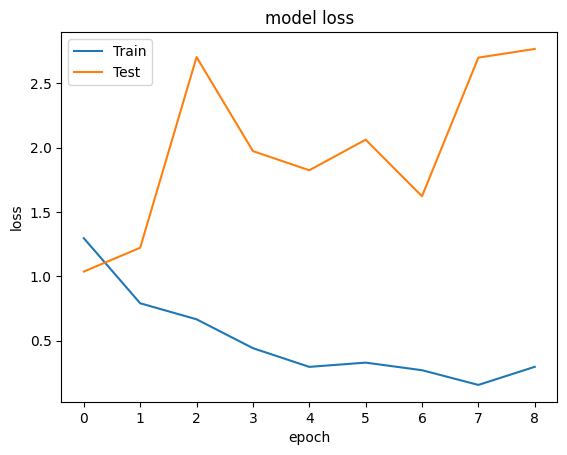

In [12]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()